This notebook shows how to crack the style encoded numbers from Dianping.

- Example URL: http://www.dianping.com/chengdu/ch10/g34060r1577

Related issues:

- [#90](https://github.com/hupili/python-for-data-and-media-communication-gitbook/issues/90)

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
url= 'http://www.dianping.com/chengdu/ch10/g34060r1577'
browser = webdriver.Chrome()
browser.get(url)
h = browser.find_element_by_css_selector('html')
t = h.get_attribute('innerHTML')
mypage = BeautifulSoup(t)
dianping_list = []
h = mypage.find('div', attrs={'class': 'content'})
i = h.find_all('div',attrs={'class':'txt'})
remark = i[0].find('div',attrs={'class':'comment'}).find('a',attrs={'class':'review-num'})

/Users/hupili/Desktop/project/python-for-data-and-media-communication/venv/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [2]:
remark

<a class="review-num" data-click-name="shop_iwant_review_click" data-shopid="75141698" href="http://www.dianping.com/shop/75141698#comment" module="list-readreview" onclick="LXAnalytics('moduleClick', 'shopreview')" rel="nofollow" target="_blank">
<b><span class="lc-Z3ef"></span><span class="lc-b91R"></span><span class="lc-1XXX"></span>1</b>
条点评</a>

## Analysis

In [4]:
from IPython.core.display import Image

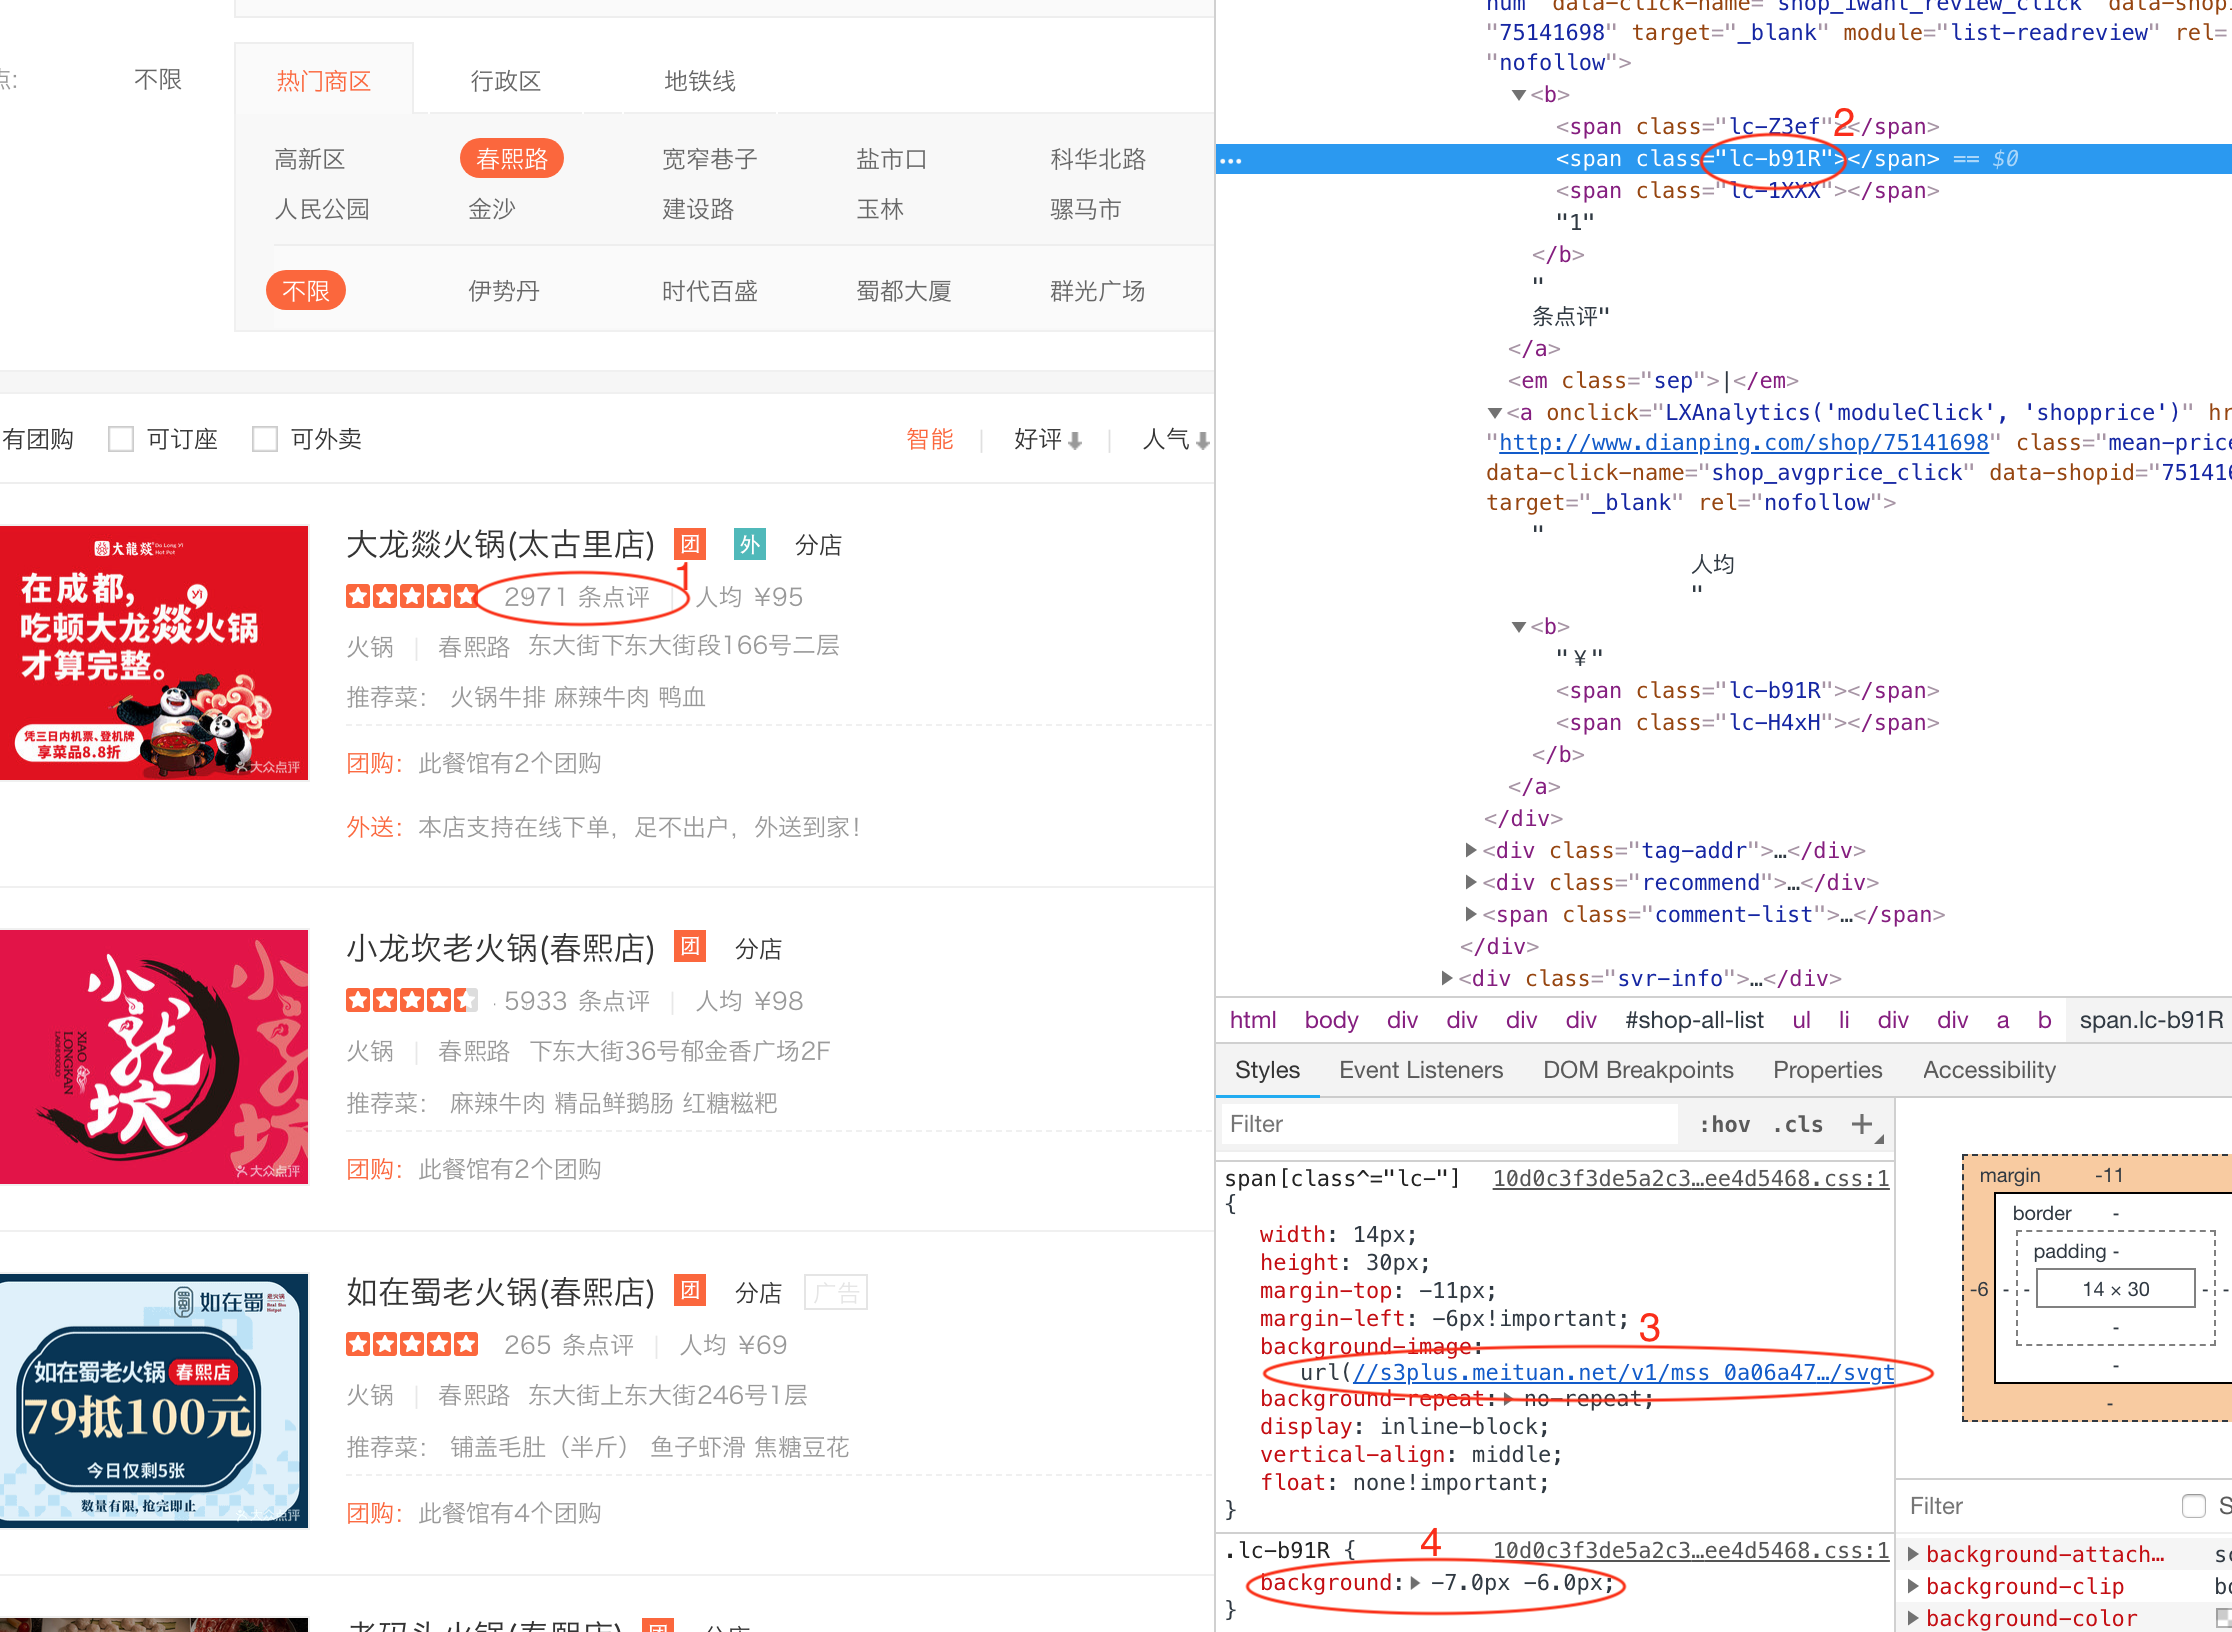

In [5]:
Image('dianping-comment-number.png')

The four steps to hide the number to computers but to "display" to humans:

1. Those are not texts. Those are `<span>` elements
2. There is a special class associated with the span.
3. All those "number" spans load a background image, which contains all the characters from 0 to 9. Checkout one [here](http://s3plus.meituan.net/v1/mss_0a06a471f9514fc79c981b5466f56b91/svgtextcss/ae2be52489fe0cffa4a810955e17cdb9.svg)
4. The special class, shifts the background of above image (SVG) so that the right character is presented.

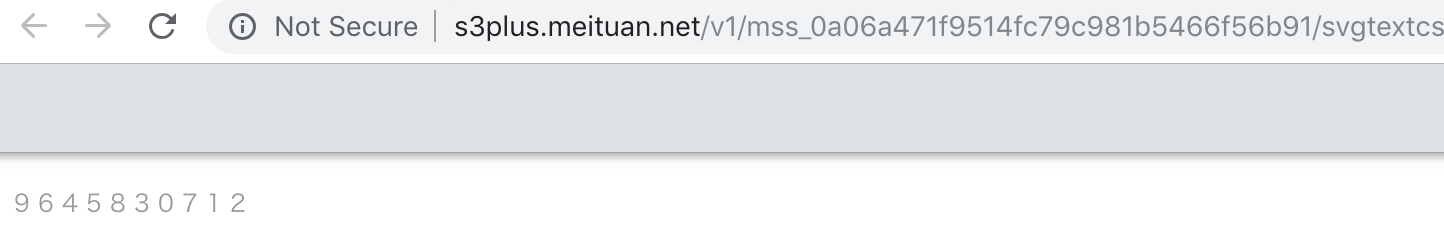

In [6]:
Image('dianping-numbers-svg.png')

I store one above so that you can see the content even when the SVG URL is changed later.

## Solution

There are several factors that may make the scraping task very difficult:

- The SVG file may change. That means the ordering of the characters may change. It is `9645830712` in my above example but may appear different for another user, or when I visit the page another time.
- The CSS class names may change.

At this stage, we are not sure how frequent those values change. However, we start with the base case, assuming those mappings do not change. The simplest way is to human label the values and apply in future scraping.

In [10]:
number_spans = browser.find_elements_by_css_selector('span[class^="lc-"]')

In [11]:
len(number_spans)

157

In [12]:
number_spans[0]

<selenium.webdriver.remote.webelement.WebElement (session="4e0a74e6dcdc3aa0d1446d730693fe1e", element="0.13457997641495356-1")>

In [13]:
s = number_spans[0]

In [17]:
s.get_attribute('class')

'lc-H4xH'

In [18]:
import pandas as pd

In [20]:
pd.Series([s.get_attribute('class') for s in number_spans]).value_counts()

lc-sx9c    45
lc-1XXX    34
lc-mY1i    14
lc-Z3ef    13
lc-b91R    12
lc-H4xH    12
lc-8YIy    12
lc-9T1T     8
lc-bJKI     7
dtype: int64

In [22]:
# from CSS class to the number
# Note: 1 is missing here; they print directly onto the page
decoder = {
    'lc-sx9c': 8,
    'lc-1XXX': 7,
    'lc-mY1i': 4,
    'lc-Z3ef': 2,
    'lc-b91R': 9,
    'lc-H4xH': 5,
    'lc-8YIy': 0,
    'lc-9T1T': 6,
    'lc-bJKI': 3
}

In [33]:
remark = i[5].find('div',attrs={'class':'comment'}).find('a',attrs={'class':'review-num'})

In [34]:
remark

<a class="review-num" data-click-name="shop_iwant_review_click" data-shopid="58322041" href="http://www.dianping.com/shop/58322041#comment" module="list-readreview" onclick="LXAnalytics('moduleClick', 'shopreview')" rel="nofollow" target="_blank">
<b><span class="lc-H4xH"></span>1<span class="lc-mY1i"></span><span class="lc-bJKI"></span></b>
条点评</a>

In [43]:
list(remark.children)

['\n',
 <b><span class="lc-H4xH"></span>1<span class="lc-mY1i"></span><span class="lc-bJKI"></span></b>,
 '\n条点评']

In [45]:
list(list(remark.children)[1].children)

[<span class="lc-H4xH"></span>,
 '1',
 <span class="lc-mY1i"></span>,
 <span class="lc-bJKI"></span>]

In [46]:
s = list(list(remark.children)[1].children)[0]

In [47]:
s

<span class="lc-H4xH"></span>

In [48]:
s.name

'span'

In [49]:
s.attrs['class']

['lc-H4xH']

In [62]:
def decode(t):
    # decode tag iteratively
    texts = []
    for c in t.children:
        if isinstance(c, str):
            texts.append(c)
            continue
        if c.name == 'span':
            #print('class', c.attrs['class'])
            texts.append(decoder.get(c.attrs['class'][0], 1))
            continue
        texts.append(decode(c))
    return ''.join(str(t) for t in texts)

In [63]:
decode(remark)

'\n5143\n条点评'

In [65]:
price = mypage.find('a', attrs={'class': 'mean-price'})

In [66]:
price

<a class="mean-price" data-click-name="shop_avgprice_click" data-shopid="75141698" href="http://www.dianping.com/shop/75141698" onclick="LXAnalytics('moduleClick', 'shopprice')" rel="nofollow" target="_blank">
            人均
            <b>￥<span class="lc-b91R"></span><span class="lc-H4xH"></span></b>
</a>

In [67]:
decode(price)

'\n            人均\n            ￥95\n'

## Puting it all together

In [68]:
h = browser.find_element_by_css_selector('html')
t = h.get_attribute('innerHTML')
mypage = BeautifulSoup(t)
dianping_list = []
h = mypage.find('div', attrs={'class': 'content'})
canteens = h.find_all('div',attrs={'class':'txt'})

/Users/hupili/Desktop/project/python-for-data-and-media-communication/venv/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [69]:
c = canteens[0]

In [72]:
remark = c.find('div',attrs={'class':'comment'}).find('a',attrs={'class':'review-num'})
decode(remark)

'\n526\n条点评'

In [74]:
price = c.find('a', attrs={'class': 'mean-price'})
decode(price)

'\n            人均\n            ￥63\n'

In [78]:
c.find('div', attrs={'class': 'tit'}).find('a').find('h4').text

'竹板凳老火锅(春熙店)'

In [80]:
c.find('span', attrs={'class': 'comment-list'})

<span class="comment-list">
<span>口味<b><span class="lc-sx9c"></span>.<span class="lc-Z3ef"></span></b></span>
<span>环境<b><span class="lc-sx9c"></span>.<span class="lc-b91R"></span></b></span>
<span>服务<b><span class="lc-sx9c"></span>.<span class="lc-9T1T"></span></b></span>
</span>

In [84]:
list(c.find('span', attrs={'class': 'comment-list'}).children)

['\n',
 <span>口味<b><span class="lc-sx9c"></span>.<span class="lc-Z3ef"></span></b></span>,
 '\n',
 <span>环境<b><span class="lc-sx9c"></span>.<span class="lc-b91R"></span></b></span>,
 '\n',
 <span>服务<b><span class="lc-sx9c"></span>.<span class="lc-9T1T"></span></b></span>,
 '\n']

In [89]:
for comment in list(c.find('span', attrs={'class': 'comment-list'}).children):
    if comment == '\n':
        continue
    print(decode(comment))

口味8.2
环境8.9
服务8.6


In [94]:
data = []
for c in canteens:
    row = []
    remark = c.find('div',attrs={'class':'comment'}).find('a',attrs={'class':'review-num'})
    row.append(decode(remark).strip())
    price = c.find('a', attrs={'class': 'mean-price'})
    row.append(decode(price).strip())
    title = c.find('div', attrs={'class': 'tit'}).find('a').find('h4').text
    row.append(title)
    for comment in list(c.find('span', attrs={'class': 'comment-list'}).children):
        if comment == '\n':
            continue
        row.append(decode(comment))
    data.append(row)

In [95]:
data

[['526\n条点评', '人均\n            ￥63', '竹板凳老火锅(春熙店)', '口味8.2', '环境8.9', '服务8.6'],
 ['2297\n条点评', '人均\n            ￥78', '逸南山鲜毛肚火锅', '口味8.1', '环境8.8', '服务8.4'],
 ['58\n条点评',
  '人均\n            ￥75',
  '五斗柴火锅鲜生(太古里店)',
  '口味8.5',
  '环境8.0',
  '服务8.4'],
 ['503\n条点评',
  '人均\n            ￥59',
  '拿东拿西自助火锅(春熙路店)',
  '口味8.0',
  '环境8.3',
  '服务8.2'],
 ['57\n条点评', '人均\n            ￥63', '灶王爷石锅老火锅', '口味8.7', '环境8.7', '服务8.5'],
 ['1718\n条点评',
  '人均\n            ￥80',
  '蜀胡记川西坝子(东门大桥店)',
  '口味8.7',
  '环境8.8',
  '服务8.9'],
 ['640\n条点评', '人均\n            ￥88', '红鼎坊(总店)', '口味8.2', '环境8.0', '服务7.9'],
 ['340\n条点评', '人均\n            ￥82', '蜀国大师(盐市口店)', '口味8.2', '环境9.1', '服务8.8'],
 ['1045\n条点评',
  '人均\n            ￥91',
  '牛莽莽老火锅(银石广场店)',
  '口味8.0',
  '环境8.8',
  '服务8.4'],
 ['532\n条点评', '人均\n            ￥77', '一条乌鱼泡龙虾', '口味7.6', '环境8.1', '服务7.7'],
 ['640\n条点评',
  '人均\n            ￥84',
  '大龙火锅(春熙路概念店)',
  '口味7.7',
  '环境8.1',
  '服务7.7'],
 ['1403\n条点评',
  '人均\n            ￥77',
  '蜀锦味老火锅(春熙路店)',
  '口味7.9',
  '环

In [96]:
pd.DataFrame(data, columns=['remark', 'price', 'title', 'flavour', 'environment', 'service'])

,remark,price,title,flavour,environment,service
0,526\n条点评,人均\n ￥63,竹板凳老火锅(春熙店),口味8.2,环境8.9,服务8.6
1,2297\n条点评,人均\n ￥78,逸南山鲜毛肚火锅,口味8.1,环境8.8,服务8.4
2,58\n条点评,人均\n ￥75,五斗柴火锅鲜生(太古里店),口味8.5,环境8.0,服务8.4
3,503\n条点评,人均\n ￥59,拿东拿西自助火锅(春熙路店),口味8.0,环境8.3,服务8.2
4,57\n条点评,人均\n ￥63,灶王爷石锅老火锅,口味8.7,环境8.7,服务8.5
5,1718\n条点评,人均\n ￥80,蜀胡记川西坝子(东门大桥店),口味8.7,环境8.8,服务8.9
6,640\n条点评,人均\n ￥88,红鼎坊(总店),口味8.2,环境8.0,服务7.9
7,340\n条点评,人均\n ￥82,蜀国大师(盐市口店),口味8.2,环境9.1,服务8.8
8,1045\n条点评,人均\n ￥91,牛莽莽老火锅(银石广场店),口味8.0,环境8.8,服务8.4
9,532\n条点评,人均\n ￥77,一条乌鱼泡龙虾,口味7.6,环境8.1,服务7.7


In [105]:
def scrape_one_page():
    h = browser.find_element_by_css_selector('html')
    t = h.get_attribute('innerHTML')
    mypage = BeautifulSoup(t)
    dianping_list = []
    h = mypage.find('div', attrs={'class': 'content'})
    canteens = h.find_all('div',attrs={'class':'txt'})
    data = []
    for c in canteens:
        try:
            row = []
            remark = c.find('div',attrs={'class':'comment'}).find('a',attrs={'class':'review-num'})
            row.append(decode(remark).strip())
            price = c.find('a', attrs={'class': 'mean-price'})
            row.append(decode(price).strip())
            title = c.find('div', attrs={'class': 'tit'}).find('a').find('h4').text
            row.append(title)
            for comment in list(c.find('span', attrs={'class': 'comment-list'}).children):
                if comment == '\n':
                    continue
                row.append(decode(comment))
            data.append(row)
        except:
            print('Failed:', c)
    return data

In [106]:
scrape_one_page()

/Users/hupili/Desktop/project/python-for-data-and-media-communication/venv/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Failed: <div class="txt">
<div class="tit">
<a data-click-name="shop_title_click" data-hippo-type="shop" data-shopid="90889972" href="http://www.dianping.com/shop/90889972" onclick="LXAnalytics('moduleClick', 'shopname');document.hippo.ext({cl_i:3,query_id:'fe4ffc60-e929-4dff-8005-2242710e7b40'}).mv('cl_to_s',90889972);" target="_blank" title="3米鸭肠老火锅">
<h4>3米鸭肠老火锅</h4>
</a>
<div class="promo-icon J_promo_icon">
</div>
</div>
<div class="comment">
<span class="sml-rank-stars sml-str30" title="三星商户"></span>
<a data-click-name="shop_iwant_review_click" data-shopid="90889972" href="http://www.dianping.com/shop/90889972/review" target="_blank">
          我要点评</a>
<em class="sep">|</em>
<a class="mean-price" data-click-name="shop_avgprice_click" data-shopid="90889972" href="http://www.dianping.com/shop/90889972" onclick="LXAnalytics('moduleClick', 'shopprice')" rel="nofollow" target="_blank">
            人均
          -
            
        </a>
</div>
<div class="tag-addr">
<a data-click-na

[['1\n条点评', '人均\n          -', '小涮锅', '口味6.9', '环境7.0', '服务6.9'],
 ['12\n条点评', '人均\n          -', '大蜀龙门火锅(春熙总店)', '口味7.0', '环境7.1', '服务6.8'],
 ['339\n条点评',
  '人均\n            ￥65',
  '雷火锅新派串串(太古里店)',
  '口味9.0',
  '环境8.7',
  '服务8.8'],
 ['428\n条点评',
  '人均\n            ￥79',
  '龍爷翻大江老火锅(春熙路总店)',
  '口味8.1',
  '环境9.0',
  '服务8.4']]

In [100]:
browser.find_element_by_css_selector('a.next').click()

In [101]:
scrape_one_page()

/Users/hupili/Desktop/project/python-for-data-and-media-communication/venv/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


[['1815\n条点评',
  '人均\n            ￥66',
  '三国烤肉海鲜欢乐自助风(春熙店)',
  '口味7.0',
  '环境7.0',
  '服务7.1'],
 ['145\n条点评', '人均\n            ￥68', '老重庆金三角串串香', '口味7.7', '环境7.0', '服务7.4'],
 ['385\n条点评',
  '人均\n            ￥74',
  '蓉城江北老灶火锅(春熙路店)',
  '口味7.2',
  '环境7.4',
  '服务6.9'],
 ['346\n条点评',
  '人均\n            ￥79',
  '围炉川西坝子火锅(总府路店)',
  '口味8.0',
  '环境8.1',
  '服务8.0'],
 ['119\n条点评',
  '人均\n            ￥79',
  '红瓦房火锅(春熙路王府井店)',
  '口味7.8',
  '环境8.1',
  '服务7.9'],
 ['1\n条点评', '人均\n          -', '囍辣火锅厅·喜辣(太古里店)', '口味7.7', '环境7.7', '服务7.7'],
 ['10\n条点评', '人均\n          -', '春熙里老火锅', '口味7.6', '环境7.8', '服务7.7'],
 ['32\n条点评', '人均\n            ￥119', '川家铺子火锅', '口味6.9', '环境7.2', '服务7.2'],
 ['201\n条点评',
  '人均\n            ￥89',
  '大道川西坝子火锅(春熙路店)',
  '口味6.8',
  '环境6.9',
  '服务7.4'],
 ['52\n条点评',
  '人均\n            ￥72',
  '味霸美蛙鱼头主题龙虾馆(香槟广场店)',
  '口味7.3',
  '环境7.1',
  '服务7.2'],
 ['276\n条点评', '人均\n            ￥68', '锦园火锅', '口味7.2', '环境8.3', '服务7.7'],
 ['4\n条点评', '人均\n          -', '大龙火锅', '口味6.9', '环境6.9', '服务6.9

In [107]:
import time

# altogether 7 pages in this search
all_data = []
for _ in range(6):
    all_data.extend(scrape_one_page())
    next_button = browser.find_element_by_css_selector('a.next')
    loc = next_button.location
    browser.execute_script("window.scrollTo({x}, {y});".format(**loc))
    next_button.click()
    time.sleep(2)
all_data.extend(scrape_one_page())

/Users/hupili/Desktop/project/python-for-data-and-media-communication/venv/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Failed: <div class="txt">
<div class="tit">
<a data-click-name="shop_title_click" data-hippo-type="shop" data-shopid="90889972" href="http://www.dianping.com/shop/90889972" onclick="LXAnalytics('moduleClick', 'shopname');document.hippo.ext({cl_i:3,query_id:'d8e8fae8-2a9e-4d66-b51a-4de443337e87'}).mv('cl_to_s',90889972);" target="_blank" title="3米鸭肠老火锅">
<h4>3米鸭肠老火锅</h4>
</a>
<div class="promo-icon J_promo_icon">
</div>
</div>
<div class="comment">
<span class="sml-rank-stars sml-str30" title="三星商户"></span>
<a data-click-name="shop_iwant_review_click" data-shopid="90889972" href="http://www.dianping.com/shop/90889972/review" target="_blank">
          我要点评</a>
<em class="sep">|</em>
<a class="mean-price" data-click-name="shop_avgprice_click" data-shopid="90889972" href="http://www.dianping.com/shop/90889972" onclick="LXAnalytics('moduleClick', 'shopprice')" rel="nofollow" target="_blank">
            人均
          -
            
        </a>
</div>
<div class="tag-addr">
<a data-click-na

Failed: <div class="txt">
<div class="tit">
<a data-click-name="shop_title_click" data-hippo-type="shop" data-shopid="110110396" href="http://www.dianping.com/shop/110110396" onclick="LXAnalytics('moduleClick', 'shopname');document.hippo.ext({cl_i:3,query_id:'1f441cf8-0d12-4276-ac96-a401c7a50345'}).mv('cl_to_s',110110396);" target="_blank" title="帮重火锅">
<h4>帮重火锅</h4>
</a>
<div class="promo-icon J_promo_icon">
</div>
<span class="istopTrade">(尚未营业)</span>
</div>
<div class="comment">
<span class="sml-rank-stars sml-str0" title="该商户暂无星级"></span>
<a data-click-name="shop_iwant_review_click" data-shopid="110110396" href="http://www.dianping.com/shop/110110396/review" target="_blank">
          我要点评</a>
<em class="sep">|</em>
<a class="mean-price" data-click-name="shop_avgprice_click" data-shopid="110110396" href="http://www.dianping.com/shop/110110396" onclick="LXAnalytics('moduleClick', 'shopprice')" rel="nofollow" target="_blank">
            人均
          -
            
        </a>
</di

In [108]:
len(all_data)

81

In [109]:
df = pd.DataFrame(all_data, columns=['remark', 'price', 'title', 'flavour', 'environment', 'service'])

In [110]:
len(df)

81

In [111]:
df

,remark,price,title,flavour,environment,service
0,2971\n条点评,人均\n ￥95,大龙燚火锅(太古里店),口味9.0,环境9.0,服务9.0
1,5933\n条点评,人均\n ￥98,小龙坎老火锅(春熙店),口味8.9,环境9.0,服务8.6
2,265\n条点评,人均\n ￥69,如在蜀老火锅(春熙店),口味9.0,环境9.1,服务9.1
3,6940\n条点评,人均\n ￥102,老码头火锅(春熙店),口味8.9,环境9.0,服务9.1
4,8374\n条点评,人均\n ￥98,小龙坎老火锅(春熙概念店),口味8.8,环境8.8,服务8.2
5,5143\n条点评,人均\n ￥95,蜀大侠火锅(春熙店),口味8.9,环境8.9,服务8.3
6,370\n条点评,人均\n ￥80,禄合門(太古里店),口味9.1,环境9.2,服务9.1
7,3782\n条点评,人均\n ￥98,蜀大侠火锅(总府路店),口味8.9,环境8.9,服务8.4
8,747\n条点评,人均\n ￥81,春熙里老火锅(春熙概念店),口味9.0,环境9.1,服务9.1
9,384\n条点评,人均\n ￥78,想吃蛙(盐市口旗舰店),口味9.1,环境9.3,服务9.2


In [112]:
df.to_csv('dianping.csv')

## Further discussion

In some other cases, you may be able to analyse the network trace in order to find the internal interface. However, this is not available on Dianping. We can find structured JSON data for suggested cateens on the sidebar, but not for the main result.

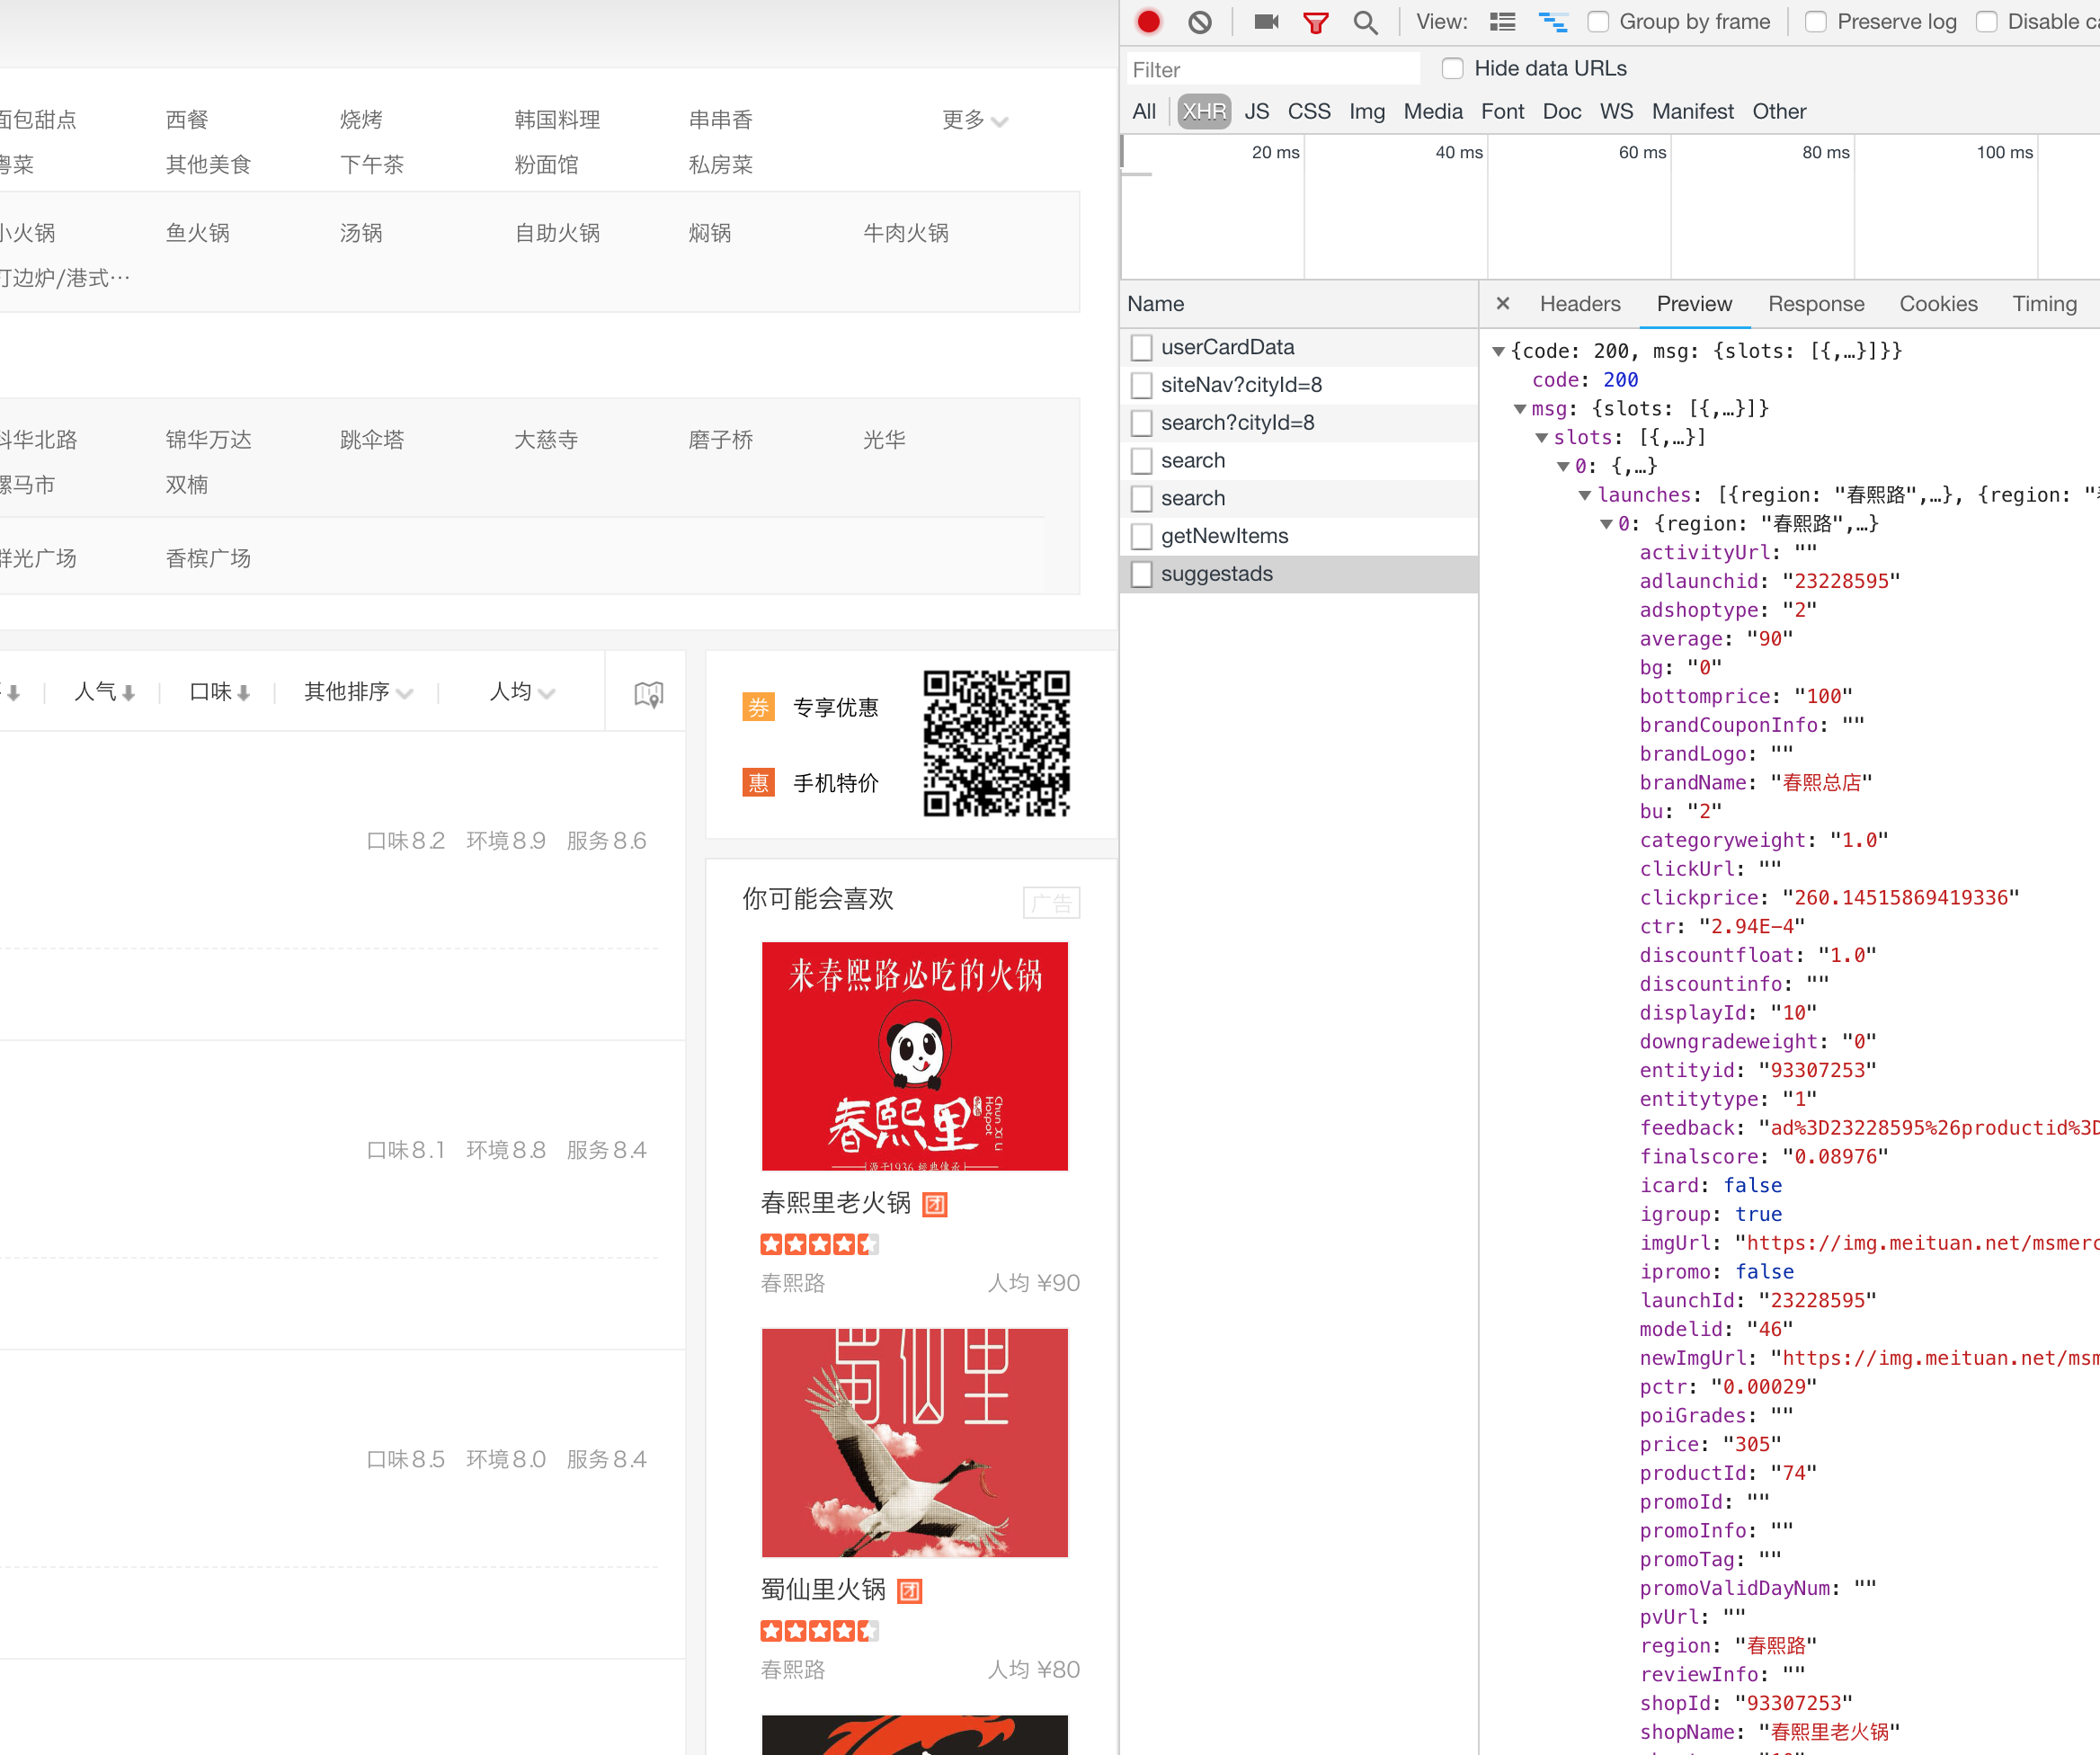

In [113]:
Image('dianping-suggestions-xhr.png')

We put it here for the completeness of discussion. Sometimes, approaching from network trace is simpler, in terms of coding.